<a href="https://colab.research.google.com/github/syadri/Multivariate-Time-Series-Forecasting-with-LSTMs/blob/main/10_mins_Forecasts_Final_LSTM_Multistep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# load and clean-up data
from numpy import nan
from numpy import isnan
import pandas as pd
from pandas import read_csv
from pandas import to_numeric
# load all data
dataset = read_csv('/content/new_data.csv', low_memory=False, infer_datetime_format=True)

dataset.columns = ['datetime', 'power']

format = '%Y-%m-%d %H:%M:%S'

dataset['datetime'] = pd.to_datetime(dataset['datetime'], format=format)

dataset = dataset.set_index(pd.DatetimeIndex(dataset['datetime']))

dataset = dataset.drop(['datetime'], axis=1)

# dataset['datetime']
dataset.head()



,power
datetime,
2021-07-16 01:01:00,3.50
2021-07-16 01:02:00,3.57
2021-07-16 01:03:00,3.45
2021-07-16 01:04:00,30.38
2021-07-16 01:05:00,29.93


In [2]:
# Resample data into 10 minute observations -- sampling interval of 10 minutes
# resample data to 10 minutes
ten_groups = dataset.resample('10T')
ten_data = ten_groups.sum()
# summarize
print(ten_data.shape)
print(ten_data.head())
# save
ten_data.to_csv('10min_samples.csv', index=False)

(715, 1)
                      power
datetime                   
2021-07-16 01:00:00  183.95
2021-07-16 01:10:00  259.25
2021-07-16 01:20:00  199.46
2021-07-16 01:30:00  183.64
2021-07-16 01:40:00  170.53


In [4]:
ten_data.tail()

,power
datetime,
2021-07-20 23:20:00,2.45
2021-07-20 23:30:00,0.38
2021-07-20 23:40:00,0.38
2021-07-20 23:50:00,0.34
2021-07-21 00:00:00,0.03


In [3]:
# evaluate one or more weekly forecasts against expected values
from sklearn.metrics import mean_squared_error
from math import sqrt
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [ ]:
data = ten_data.copy()

data.head()

##Splitting Dataset

---



In [10]:
# we have 715 total observations now over the course of 5 days 16th to 21st

# split into standard 10 minutes
from numpy import split
from numpy import array

# 1 day == 1440 minutes. 144 - 10 minute intervals So 4 days == 144*4 == 576



# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into days -- 144 total observations per day(10 minute intervals) || Using first 4 days (144*4) for training a last 144 for testing
	# Make it devisible by 10, so first 570 observations for training and next 140 for testing. we leave out the ramining 50 minute observations

 # So we take 140 since 145 is not equally divisible by 10 and we leave out the last 5 (5*10 mins)
	train, test = data[:570], data[570:710]
	# restructure into windows of daily data
  #Since we have 4 days of training data, resampled into 10 minute intervals we devide by 10
	train = array(split(train, len(train)/10))
	test = array(split(test, len(test)/10))

  # print(len(train))
	return train, test

train, test = split_dataset(data.values)

# # validate train data
print(train.shape)

# # validate test
print(test.shape)




(57, 10, 1)
(14, 10, 1)


In [11]:
# We can see that the total active power for the train and test dataset for the first and last rows
# match the data for the specific dates that we defined as the bounds on the standard weeks for each set.

print(train[0, 0, 0], train[-1, -1, 0], sep='\n')

183.95
3.06


## Building the model

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


def to_supervised(train, n_input, n_out=10):
	data = train.reshape((train.shape[0]*train.shape[1], 1))
	X, y = list(), list()
	in_start = 0
	for _ in range(len(data)):
		in_end = in_start + n_input
		out_end = in_end + n_out
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		in_start += 1
	return np.array(X), np.array(y)

In [20]:
train, test = split_dataset(ten_data.values)
train_x, train_y = to_supervised(train, 10, 10)

In [21]:
verbose, epochs, batch_size = 1, 15, 2
# choose a number of time steps
n_steps = 10
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(100, activation='relu'))
model.add(Dense(10))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
# demonstrate prediction

Epoch 1/15
276/276 [==============================] - 5s 15ms/step - loss: 308976.4688
Epoch 2/15
276/276 [==============================] - 4s 16ms/step - loss: 145343.0156
Epoch 3/15
276/276 [==============================] - 4s 14ms/step - loss: 150312.4844
Epoch 4/15
276/276 [==============================] - 5s 17ms/step - loss: 108762.1641
Epoch 5/15
276/276 [==============================] - 4s 14ms/step - loss: 129380.2266
Epoch 6/15
276/276 [==============================] - 4s 14ms/step - loss: 76593.0156
Epoch 7/15
276/276 [==============================] - 4s 15ms/step - loss: 87584.3203
Epoch 8/15
276/276 [==============================] - 4s 14ms/step - loss: 641295.2500
Epoch 9/15
276/276 [==============================] - 4s 15ms/step - loss: 261332.7969
Epoch 10/15
276/276 [==============================] - 4s 15ms/step - loss: 192093.1406
Epoch 11/15
276/276 [==============================] - 4s 15ms/step - loss: 224601.1094
Epoch 12/15
276/276 [======================

In [22]:
yhat = model.predict(test[:-1], verbose=verbose)

1/1 [==============================] - 0s 181ms/step


In [23]:
yy = yhat.flatten()
yx = test[1:].flatten()

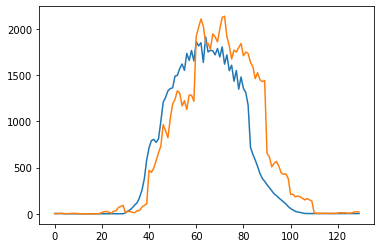

In [24]:
plt.plot(range(len(yy)), yx, yy)

In [25]:
# Save to DataFrame and then to file

new_df = pd.DataFrame()

new_df['Actual'] = yx
new_df['Predicted'] = yy
new_df.to_csv('./predicted_vals.csv')